In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
import vector
import awkward as ak
import mplhep as hep

# hep.style.use(hep.style.ROOT)
hep.style.use("ATLAS")

In [200]:
"""Read in SM and EFT data from .npy files
Set run variable to the folder containing the set of selections applied to the data
which is usually the date ran in the format 'ddmmyy"""
# sm_run = '130424'
sm_run = 'test'
# sm_run = '130424_ditau_cut'
# sm_run = 'zh_full_cuts'
# sm_run = '300424_cut'
# eft_run = '090324_2'
# eft_run = '130324_chbtil_0.1'
# eft_run = '050424_chbtil_0.5'
# eft_run = 'chbtil_0.5_cut'
# eft_run = 'chbtil_25.0'
# eft_run = 'zh_chbtil_10_full_cuts'
eft_run = 'chbtil_10'

'Each element in the list is a numpy array of the data for one sample run'
sm_tau_data = []
sm_muon_data = []
sm_weights = []

# Change commented out code if testing with different data

for i in range(1,2):
    sm_tau_data.append(np.load(f'sm_data/{sm_run}/sm_taus_run_{i}.npy'))
    sm_muon_data.append(np.load(f'sm_data/{sm_run}/sm_muons_run_{i}.npy'))
    sm_weights.append(np.load(f'sm_data/{sm_run}/sm_weights_run_{i}.npy'))

eft_tau_data = []
eft_muon_data = []
eft_weights= []

# eft_tau_data.append(np.load(f'eft_data/{eft_run}/eft_taus_run_1.npy'))
# eft_muon_data.append(np.load(f'eft_data/{eft_run}/eft_muons_run_1.npy'))
# eft_weights.append(np.load(f'eft_data/{eft_run}/eft_weights_run_1.npy'))

for i in range(1,36):
    eft_tau_data.append(np.load(f'eft_data/chbtil_{i}/eft_taus_run_1.npy'))
    eft_muon_data.append(np.load(f'eft_data/chbtil_{i}/eft_muons_run_1.npy'))
    eft_weights.append(np.load(f'eft_data/chbtil_{i}/eft_weights_run_1.npy'))

# eft_runs = ['chbtil_10', 'chwtil_10', 'chwbtil_10']

# for i in eft_runs:
#     eft_tau_data.append(np.load(f'eft_data/{i}/eft_taus_run_1.npy'))
#     eft_muon_data.append(np.load(f'eft_data/{i}/eft_muons_run_1.npy'))
#     eft_weights.append(np.load(f'eft_data/{i}/eft_weights_run_1.npy'))


# for i in range(1,6):
#     eft_tau_data.append(np.load(f'eft_data/{eft_run}/eft_taus_run_{i}.npy'))
#     eft_muon_data.append(np.load(f'eft_data/{eft_run}/eft_muons_run_{i}.npy'))
#     eft_weights.append(np.load(f'eft_data/{eft_run}/eft_weights_run_{i}.npy'))

In [102]:
"""This is a very messy method of reading in the data
and reconstructing the vectors.
It is definitely worth revisiting
though it saves having to run the selections every time

The .npy files seem to save data for each tau as:
(pt, phi, eta, mass, charge, tautag)"""

sm_taus = []
for j in sm_tau_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    tautag = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]]) # NOTE these are flipped with eta!
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        charge.append([i[0][4], i[1][4]])
        tautag.append([i[0][5], i[1][5]])
    taus = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass,'charge':charge,'tautag':tautag})
    sm_taus.append(taus)

eft_taus = []
for j in eft_tau_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    tautag = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]])
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        charge.append([i[0][4], i[1][4]])
        tautag.append([i[0][5], i[1][5]])
    taus = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass,'charge':charge,'tautag':tautag})
    eft_taus.append(taus)

"""The .npy files seem to save data for each muon as:
(pt, phi, eta, mass)"""

sm_muons = []
for j in sm_muon_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]])
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        try:
            charge.append([i[0][4], i[1][4]])
        except:
            pass
    if len(charge) > 0:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass, 'charge':charge})
    else:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass})
    sm_muons.append(muons)

eft_muons = []
for j in eft_muon_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]])
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        try:
            charge.append([i[0][4], i[1][4]])
        except:
            pass
    if len(charge) > 0:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass, 'charge':charge})
    else:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass})
    eft_muons.append(muons)

In [4]:
"""All function definitions below"""

"""Plot the ditau invariant mass distribution
using whichever event mask is passed to it given the current cuts"""
def ditau_inv_mass(ditau, weights, model):
    #calculate the ditau invariant mass and plot it using matplotlib
    ditau_mass = (ditau[:,0]+ditau[:,1]).mass
    plt.hist(ditau_mass, bins=25, histtype='step', color='k', weights=weights)
    plt.xlabel('Mass [GeV]')
    plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$')
    plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
    plt.title(r'{} di-$\tau$ invariant mass distribution'.format(model.upper()))
    plt.savefig("ditau_mass_{}.png".format(model))
def return_inv_masses(leptons):
    return (leptons[:,0]+leptons[:,1]).mass
def histogram(data, weights, bins, label, colour, range, plot = True):
    """Unfortunately, plt.hist does not support error bars, so we have to use plt.errorbar
    using manual inputs from np.histogram"""
    # histogram of cross section for later analysis
    nphisto = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
    err = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
    # histogram of differential cross section
    bin_width = (range[1]-range[0])/bins
    weights = weights/bin_width
    nphisto_diff = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
    err_diff = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
    if plot:
        plt.hist(data, bins=bins, histtype='step', range = range, color=colour, weights=weights, label = r'{}'.format(label))
        plt.errorbar(nphisto_diff[1][:-1]+((range[1]-range[0])/(2*bins)), nphisto_diff[0], yerr=np.sqrt(err_diff[0]), fmt='.', color=colour)
        plt.xlim(range)
        plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
        plt.legend(fontsize = 18)
    return nphisto, np.sqrt(err[0]), nphisto_diff, np.sqrt(err_diff[0])
def SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, sm_diff, sm_diff_err, eft_diff, eft_diff_err, bins, label, colour, range):
    # Cross section histogram for SM and EFT data, for limit setting
    smeft_histo = sm_histo[0] + eft_histo[0]
    smeft_err = np.sqrt(sm_err**2 + eft_err**2)
    smeft_diff = sm_diff[0] + eft_diff[0]
    smeft_diff_err = np.sqrt(sm_diff_err**2 + eft_diff_err**2)
    # Plot differential cross section
    plt.errorbar(sm_diff[1][:-1]+((range[1]-range[0])/(2*bins)), smeft_diff, yerr=smeft_diff_err, fmt='.', color=colour)
    smeft_histo_full = np.append(smeft_diff, smeft_diff[-1])
    plt.step(sm_diff[1], smeft_histo_full, where='post', color=colour, label=label)
    plt.xlim(range)
    plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
    plt.legend(fontsize = 18)
    return smeft_histo, smeft_err
# def likelihood(smeft, sm, sm_data):
#     """Calculate the likelihood ratio for each event"""
#     sm_total = np.sum(sm)
#     sm_scale = len(sm_data) * 1.7*10**(-5)
#     sm_events = [round((i/sm_total) * sm_scale) for i in sm]
#     smeft_total = np.sum(smeft)
#     smeft_scale = len(sm_data) * 1.7*10**(-5)
#     smeft_events = [(i/smeft_total) * smeft_scale for i in smeft]
#     likelihood_ratio = 1
#     for i, j in zip(sm_events, smeft_events):
#         expo = math.exp(-j)
#         power = j**i
#         factorial = math.factorial(i)
#         likelihood_ratio *= math.exp(-j) * (j**i) / math.factorial(i)
#     return likelihood_ratio

"""Try a new approach
number of expected events = cross section * luminosity * efficiency
so for events we just multiply bin by luminosity....?"""

def likelihood(smeft, sm):
    luminosity = 1.7 * 10**(6) # pb^-1
    #luminosity = (1.7495873e-05)**(-1)
    sm_events = sm * luminosity
    smeft_events = smeft * luminosity
    print('Background event yields: ', sm_events)
    print('total yield: ', sum(sm_events))
    print('Background + signal event yields: ', smeft_events)
    print('total yield: ', sum(smeft_events))
    likelihood = 1
    for i, j in zip(sm_events, smeft_events):
        # expo = math.exp(-j)
        # power = j**i
        # factorial = math.factorial(round(i))
        # print(expo, power, factorial)
        likelihood *= math.exp(-j) * (j**i) / math.gamma(i+1) # approximate as integer? NOTE: gamma function defined with the +1
    return likelihood
"""Bohm-Zech method of calculating the likelihood ratio"""

def likelihood_bz(sm, sm_err, smeft, smeft_err, eft_err):
    luminosity = 1.7 * 10**(6) # pb^-1
    sm_events = sm * luminosity
    smeft_events = smeft * luminosity
    sm_s = [i/j for i,j in zip(sm, sm_err)]
    smeft_s = [i/j for i,j in zip(smeft, sm_err+eft_err)] # adding (not in quadrature)
    sm_prime = [i/j for i,j in zip(sm_events, sm_s)]
    smeft_prime = [i/j for i,j in zip(smeft_events, smeft_s)]
    H1 = log_L(sm_prime, sm_prime)
    H0 = log_L(smeft_prime, sm_prime)
    # H1 = log_L(sm_prime, sm_prime)
    # H0 = log_L(sm_prime, smeft_prime)
    q = 2*(H1-H0)
    return q

def log_L(mu, n):
    log_L = 0
    for i, j in zip(mu, n):
        log_L += j*math.log(i) - i
    return log_L

from iminuit import Minuit
from iminuit.cost import BinnedNLL

"need to define a cdf"
def cdf(x, mu, sigma):
    """What model is this?????"""
    pass

def p_val_minuit(smeft, sm, luminosity = 1.7 * 10**(6)):
    xe = sm[1]
    n_smeft = smeft * luminosity
    n_sm = sm[0] * luminosity
    return(sm[1])
    # c = BinnedNLL(smeft, sm)
    # m = Minuit(c, pedantic=False)
    # m.migrad()
    # return m.values, m.errors

def np_q(H0, H1):
    return -2*np.log(H0/H1)
def delta_phi_rapidity(leptons):
    delta_phi_lep_y = []
    for i in leptons:
        if i[0].rapidity > i[1].rapidity:
            delta_phi_lep_y.append(i[0].deltaphi(i[1]))
        else:
            delta_phi_lep_y.append(i[1].deltaphi(i[0]))
    return delta_phi_lep_y
from scipy.stats import chi2

def find_p_val(likelihood, ndof):
    return 1 - chi2.cdf(likelihood, ndof)
def n_events_histo(data, weights, bins, label, colour, range, plot = True):
    """Unfortunately, plt.hist does not support error bars, so we have to use plt.errorbar
    using manual inputs from np.histogram"""
    # histogram of cross section for later analysis
    luminosity = 1.7 * 10**(6) # pb^-1
    weights = weights * luminosity
    nphisto = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
    err = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
    # histogram of number of events
    if plot:
        plt.hist(data, bins=bins, histtype='step', range = range, color=colour, weights=weights, label=label)
        plt.errorbar(nphisto[1][:-1]+((range[1]-range[0])/(2*bins)), nphisto[0], yerr=np.sqrt(err[0]), fmt='.', color=colour)
        plt.xlim(range)
        plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
        plt.legend()
    return nphisto, np.sqrt(err[0])
def n_smeft_histo(sm_histo, sm_err, eft_histo, eft_err, bins, label, colour, range):
    # Cross section histogram for SM and EFT data, for limit setting
    smeft_histo = sm_histo[0] + eft_histo[0]
    smeft_err = np.sqrt(sm_err**2 + eft_err**2)
    # Plot differential cross section
    plt.errorbar(sm_histo[1][:-1]+((range[1]-range[0])/(2*bins)), smeft_histo, yerr=smeft_err, fmt='.', color=colour)
    smeft_histo_full = np.append(smeft_histo, smeft_histo[-1])
    plt.step(sm_histo[1], smeft_histo_full, where='post', color=colour, label=label)
    plt.xlim(range)
    plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
    plt.legend()
    return smeft_histo, smeft_err

In [191]:
"""Plot the delta phi between the two taus ordered by rapidity
set sm and eft to the index of the sample run"""

sm = 1
eft = 1
bins = 14
plot_range = (-math.pi, math.pi)

delta_phi_tau_y_sm = delta_phi_rapidity(sm_taus[sm-1])
delta_phi_tau_y_eft = delta_phi_rapidity(eft_taus[eft-1])

histogram(delta_phi_tau_y_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_phi_tau_y_eft, eft_weights[eft-1], bins, r'$c_{H\widetilde{B}} / \Lambda^2 = 25.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)
plt.xlabel(r'$\Delta \Phi$ [rad]')
plt.ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \phi_{\mu \mu})}$ [pb/rad]')
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\tau_1$ and $\tau_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 1.00')
plt.title(r'Rapidity ordered $\Delta \phi_{\tau \tau}$')
plt.text(0.4, 0.85, r'$\sqrt{s} = 0.24$ TeV, 14 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.375, 0.8, r'$e^+ e^- \rightarrow (Z h) \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)
plt.legend(loc = 'lower center', fontsize = 18)
plt.savefig("delta_phi_tau_y.pdf")

ValueError: weights should have the same shape as a.

In [193]:
"""Plot the delta phi between the two muons ordered by rapidity
set sm and eft to the index of the sample run"""
sm = 1
eft = 1
bins = 14
plot_range = (-math.pi, math.pi)

delta_phi_mu_y_sm = delta_phi_rapidity(sm_muons[sm-1])
delta_phi_eft_chb = delta_phi_rapidity(eft_muons[0])
delta_phi_eft_chw = delta_phi_rapidity(eft_muons[1])
delta_phi_eft_chwb = delta_phi_rapidity(eft_muons[2])

histogram(delta_phi_mu_y_sm, sm_weights[sm-1] / 6, bins, 'SM / 6', 'k', plot_range)
plt.ylim(-4.5e-7, 4.5e-7)
histogram(delta_phi_eft_chb, eft_weights[0], bins, r'$c_{H\widetilde{B}} / \Lambda^2 = 1.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)
histogram(delta_phi_eft_chw, eft_weights[1], bins, r'$c_{H\widetilde{W}} / \Lambda^2 = 1.0 \, \text{TeV}^{-2}$', 'royalblue', plot_range)
histogram(delta_phi_eft_chwb, eft_weights[2], bins, r'$c_{H\widetilde{W}B} / \Lambda^2 = 1.0 \, \text{TeV}^{-2}$', 'darkgreen', plot_range)
plt.xlabel(r'$\Delta \Phi$ [rad]')
plt.ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \phi_{\mu \mu})}$ [pb/rad]')
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\tau_1$ and $\tau_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 1.00')
plt.title(r'Rapidity ordered $\Delta \phi_{\mu \mu}$')
plt.text(0.4, 0.85, r'$\sqrt{s} = 0.24$ TeV, 14 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.375, 0.8, r'$e^+ e^- \rightarrow (Z h) \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)
plt.legend(loc = 'lower left', fontsize = 18)
plt.savefig("delta_phi_mu_separate.pdf")

IndexError: list index out of range

In [184]:
start = 1
choice = 29
eft =choice - start + 1
# eft = 1

q:  3.3878396444283885
a =  0.06567895145919789
Background event yields:  [1.5265341  1.854605   1.2319398  0.36154756 0.17407845 0.06025792
 0.04017195 0.04686727 0.10042988 0.1874691  0.28120366 1.2386351
 1.6202687  1.339065  ]
SM error:  [0.10109719 0.11143242 0.09081981 0.04920039 0.03413959 0.02008598
 0.01640013 0.01771416 0.02593088 0.03542833 0.04339067 0.09106627
 0.10415481 0.09468619]
total yield:  10.063073340803385
max yield:  10.89862015814737
min yield:  9.2275265234594
0.8355468173439853 0.8355468173439853
Background + signal event yields:  [1.3701434  2.8242278  1.8262248  0.54921645 0.29919103 0.06025792
 0.0714501  0.04686727 0.10042988 0.15619095 0.24992551 0.4566813
 0.77575856 0.8698927 ]
SMEFT error:  [0.24914202 0.48626443 0.44171018 0.17266649 0.10463622 0.04858078
 0.03531695 0.01771416 0.02593088 0.10029991 0.17393709 0.45700025
 0.45765461 0.28004712]
total yield:  9.656457725912333
max yield:  12.707358827012381
min yield:  6.605556624812282
3.050901101100

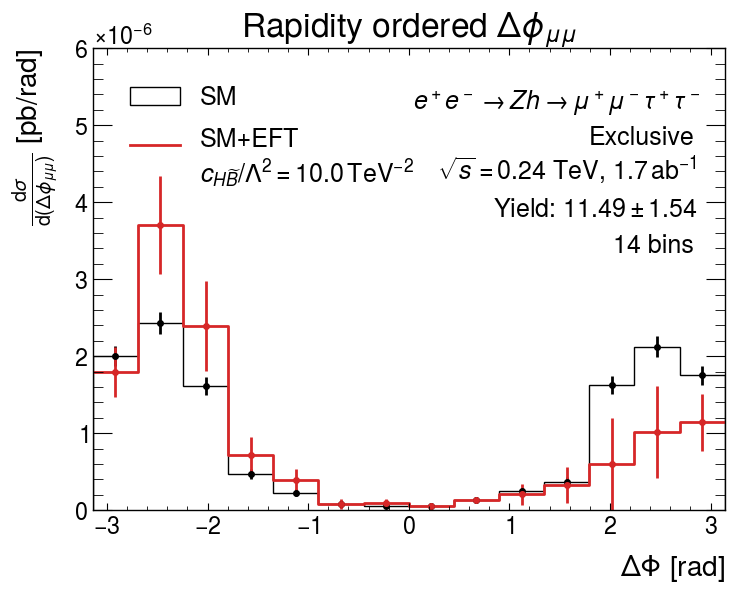

In [185]:
"""Plot the delta phi between the two muons ordered by rapidity
set sm and eft to the index of the sample run"""
sm = 1
# eft = 1
bins = 14
plot_range = (-math.pi, math.pi)
luminosity = 1.7 * 10**(6) # pb^-1

delta_phi_mu_y_sm = delta_phi_rapidity(sm_muons[sm-1])
delta_phi_mu_y_eft = delta_phi_rapidity(eft_muons[eft-1])
# print(len(delta_phi_mu_y_sm), len(delta_phi_mu_y_eft))

sm_histo, sm_err, sm_diff, sm_diff_err = histogram(delta_phi_mu_y_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err, eft_diff, eft_diff_err = histogram(delta_phi_mu_y_eft, eft_weights[eft-1], bins, 'EFT', 'k', plot_range, False)
smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, sm_diff, sm_diff_err, eft_diff, eft_diff_err, bins,
                                         '\nSM+EFT\n' + r'$c_{H\widetilde{B}} / \Lambda^2 = 10.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)
# print(p_val_minuit(smeft_histo, sm_histo, luminosity))
"""How to define H1, H0?"""
# H1 = likelihood(smeft_histo, sm_histo[0])
# H0 = likelihood(sm_histo[0], sm_histo[0])
"""or???"""
# H1 = likelihood(smeft_histo, smeft_histo)
# H0 = likelihood(smeft_histo, sm_histo[0])
"""
H0 = likelihood(smeft_histo, sm_histo[0])
H1 = likelihood(sm_histo[0], sm_histo[0])
"""
# print('H1 Likelihood: ', H1,'\nH0 Likelihood: ', H0)
# print('q: ', np_q(H0,H1))
# print('a = ', find_p_val(np_q(H0,H1), bins-1))
# colours = ['r', 'g', 'b', 'c', 'm']
# for i in range(1,6):
#     delta_phi_mu_y_eft = delta_phi_rapidity(eft_muons[i-1])
#     eft_histo, eft_err = histogram(delta_phi_mu_y_eft, eft_weights[i-1], bins, f'EFT run {i}', 'r',  plot_range, False)
#     smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, bins, f'SM+EFT {i}', colours[i-1], plot_range)


"""Bohm-Zech method"""
q = likelihood_bz(sm_histo[0], sm_err, smeft_histo, smeft_err, eft_err) # slightly confusing but these are all the relevant arrays
print('q: ', q)
print('a = ', find_p_val(q, 1))

# shift = np.ones(len(sm_histo[0])) * 5e-06
# test = np.array([6,5,4,3,2,1,1,2,3,4,5,6]) * 5e-06
# print(sm_histo[0], sm_histo[0]+test)
# q_alt = likelihood_bz(sm_histo[0]+test, sm_err, smeft_histo, smeft_err, eft_err)
# print('q_alt: ', q_alt)
# print('a_alt = ', find_p_val(q_alt, bins-1))

luminosity = 1.7 * 10**(6) # pb^-1
sm_n_events = sm_histo[0] * luminosity
smeft_n_events = smeft_histo * luminosity
sm_n_error = sm_err * luminosity
smeft_n_error = smeft_err * luminosity
sm_total_yield = sum(sm_n_events)
sm_max_yield = sum(sm_n_events + sm_n_error)
sm_min_yield = sum(sm_n_events - sm_n_error)
print('Background event yields: ', sm_n_events)
print('SM error: ', sm_n_error)
print('total yield: ', sm_total_yield)
print('max yield: ', sm_max_yield)
print('min yield: ', sm_min_yield)
print(sm_max_yield - sm_total_yield, sm_total_yield - sm_min_yield)
print('Background + signal event yields: ', smeft_n_events)
print('SMEFT error: ', smeft_n_error)
smeft_total_yield = sum(smeft_n_events)
print('total yield: ', smeft_total_yield)
smeft_max_yield = sum(smeft_n_events + smeft_n_error)
print('max yield: ', smeft_max_yield)
smeft_min_yield = sum(smeft_n_events - smeft_n_error)
print('min yield: ', smeft_min_yield)
print(smeft_max_yield - smeft_total_yield, smeft_total_yield - smeft_min_yield)

plt.xlabel(r'$\Delta \Phi$ [rad]')
# plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \phi_{\mu \mu})}$ [pb/rad]')
plt.ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \phi_{\mu \mu})}$ [pb/rad]')
plt.ylim(0, 0.6e-5)
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n' + r'$c_{H\widetilde{B}}$ = 10.0')
plt.title(r'Rapidity ordered $\Delta \phi_{\mu \mu}$')
# plt.text(-2.75, 1.25e-5, r'$\sqrt{s} = 0.24$ TeV', fontsize=18)
plt.text(0.59, 0.71, r'$\sqrt{s} = 0.24$ TeV, $1.7 \, \text{ab}^{-1}$', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.81, 0.59, '14 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.66, 0.65, r'Yield: $11.49 \pm 1.54$', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.78, 0.77, 'Exclusive', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.56, 0.83, r'$e^+ e^- \rightarrow Z h \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)

# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + '\n chbtil = 0.1')
plt.legend(fontsize = 18, labelspacing = -0.5, loc = 'upper left')
plt.savefig("delta_phi_mu_y.pdf")

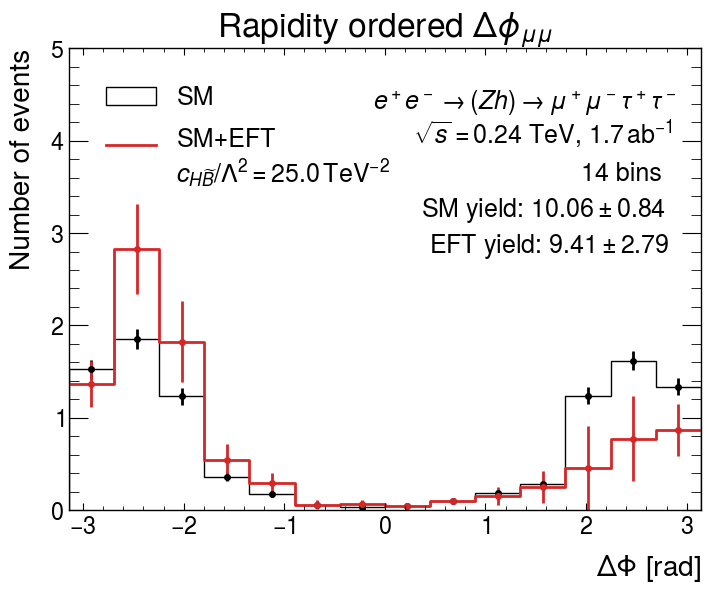

In [186]:
"""Plot above but as number of events"""
sm = 1
# eft = 1
bins = 14
plot_range = (-math.pi, math.pi)
luminosity = 1.7 * 10**(6) # pb^-1

delta_phi_mu_y_sm = delta_phi_rapidity(sm_muons[sm-1])
delta_phi_mu_y_eft = delta_phi_rapidity(eft_muons[eft-1])
# print(len(delta_phi_mu_y_sm), len(delta_phi_mu_y_eft))

sm_histo, sm_err = n_events_histo(delta_phi_mu_y_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err= n_events_histo(delta_phi_mu_y_eft, eft_weights[eft-1], bins, 'EFT', 'k', plot_range, False)
smeft_histo, smeft_err = n_smeft_histo(sm_histo, sm_err, eft_histo, eft_err, bins,
                                         '\nSM+EFT\n' + r'$c_{H\widetilde{B}} / \Lambda^2 = 25.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)
plt.xlabel(r'$\Delta \Phi$ [rad]')
# plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \phi_{\mu \mu})}$ [pb/rad]')
plt.ylabel('Number of events')
plt.ylim(0, 5)
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n' + r'$c_{H\widetilde{B}}$ = 10.0')
plt.title(r'Rapidity ordered $\Delta \phi_{\mu \mu}$')
# plt.text(-2.75, 1.25e-5, r'$\sqrt{s} = 0.24$ TeV', fontsize=18)   
plt.text(0.59, 0.77, r'$\sqrt{s} = 0.24$ TeV, $1.7 \, \text{ab}^{-1}$', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.8, 0.71, '14 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.6, 0.65, r'SM yield: $10.06 \pm 0.84$', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.61, 0.59, r'EFT yield: $9.41 \pm 2.79$', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.54, 0.83, r'$e^+ e^- \rightarrow (Z h) \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + '\n chbtil = 0.1')
plt.legend(fontsize = 18, labelspacing = -0.5, loc = 'upper left')
plt.savefig("delta_phi_mu_y_n_events.pdf")

In [187]:
"""CLs method"""

import pyhf
from pyhf.contrib.viz import brazil
bkg_error = np.sqrt(sm_err)
pyhf.set_backend("numpy")
model = pyhf.simplemodels.uncorrelated_background(
    signal=eft_histo[0].tolist(),
    bkg=sm_histo[0].tolist(),
    bkg_uncertainty=bkg_error.tolist()
)

data = sm_histo[0].tolist() + model.config.auxdata
test_mu = 1.0


CLs_obs, CLs_exp, set = pyhf.infer.hypotest(test_mu, data, model, test_stat='qtilde', return_expected=True, return_expected_set=True)
print(f"Expected: {CLs_exp:.8f}, Observed: {CLs_obs:.8f}")
print(set)
print(set[2]-set[1], set[3] - set[2])

# poi_vals = np.linspace(0, 1, 11)
# results = [
#     pyhf.infer.hypotest(
#         test_poi, data, model, test_stat="qtilde", return_expected_set=True
#     )
#     for test_poi in poi_vals
# ]

# fig, ax = plt.subplots()
# fig.set_size_inches(7, 5)
# brazil.plot_results(poi_vals, results, ax=ax)
# fig.show()

Expected: 0.13399589, Observed: 0.13399589
[array(0.01028197), array(0.03930219), array(0.13399589), array(0.36733534), array(0.70808933)]
0.09469370425996597 0.23333944606200327


In [241]:
'''Check cross section magnitudes by integrating the histograms
and comparing to the madgraph cross section * efficiency of selection'''

bin_width = (plot_range[1] - plot_range[0]) / bins

from_diff_sm = sm_histo[0] * bin_width
from_diff_eft = eft_histo[0] * bin_width

print('Integrated SM cross section  (from diff):', np.sum(from_diff_sm))
print('Integrated EFT cross section (from diff):', np.sum(from_diff_eft))

print('Integrated SM cross section:', np.sum(sm_histo[0]))
print('Integrated EFT cross section:', np.sum(eft_histo[0]))

sm_cross_sections = [0.00022695, 0.00022707, 0.00022714, 0.00022703, 0.00022693]
eft_cross_sections = [-8.8921e-07, -1.291e-07, 9.4202e-07, 0.00016228, 2.2907e-06]

import uproot

sm_tree = uproot.open(f'../../Final_Samples/delphes_ee_zh_mumutautau_sm_PDFs_50000events_230224_Run{sm}.root:Delphes')
sm_events = sm_tree.arrays(['Event.Weight'])
eft_tree = uproot.open(f'../../Final_Samples/delphes_ee_mumutautau_smeft_PDFs_50000events_040324_Run{eft}.root:Delphes')
eft_events = eft_tree.arrays(['Event.Weight'])

sm_efficiency = len(sm_muons[sm-1])/len(sm_events)
eft_efficiency = len(eft_muons[eft-1])/len(eft_events)

print('Madgraph SM cross section:', sm_cross_sections[sm-1] * sm_efficiency)
print('Madgraph EFT cross section:', eft_cross_sections[eft-1] * eft_efficiency)
print('Madgraph SM expected number of events:', sm_cross_sections[sm-1] * sm_efficiency * 1.7 * 10**(6))

Integrated SM cross section  (from diff): 2.6566456e-06
Integrated EFT cross section (from diff): -5.4073737e-08
Integrated SM cross section: 5.9194545e-06
Integrated EFT cross section: -1.2048547e-07
Madgraph SM cross section: 9.178394413948981e-06
Madgraph EFT cross section: -2.408624364930584e-08
Madgraph SM expected number of events: 15.603270503713267


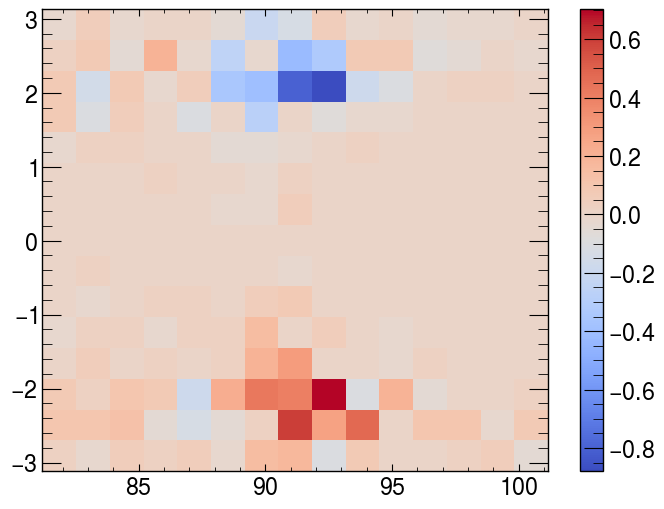

In [23]:
# sm = 1
eft = 1
bins = 12
phi_plot_range = [-math.pi, math.pi]
mass_plot_range = [0,120]
luminosity = 1.7 * 10**(6) # pb^-1

bins = 15

# delta_phi_mu_y_sm = delta_phi_rapidity(sm_muons[sm-1])
delta_phi_mu_y_eft = delta_phi_rapidity(eft_muons[eft-1])

weights = eft_weights[eft-1] * luminosity
phi_bin_width = (phi_plot_range[1]-phi_plot_range[0])/bins
phi_weights = weights/phi_bin_width
mass_bin_width = (mass_plot_range[1]-mass_plot_range[0])/bins
mass_weights = weights/mass_bin_width

inv_masses = return_inv_masses(eft_muons[eft-1]).tolist()

weights = [i[0] for i in weights]

phi_weights = [i[0] for i in phi_weights]
mass_weights = [i[0] for i in mass_weights]


plt.hist2d(inv_masses, delta_phi_mu_y_eft, bins=bins, weights = weights, cmap='coolwarm')
plt.colorbar()
plt.show()

# def histogram(data, weights, bins, label, colour, range, plot = True):
#     """Unfortunately, plt.hist does not support error bars, so we have to use plt.errorbar
#     using manual inputs from np.histogram"""
#     # histogram of cross section for later analysis
#     nphisto = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
#     err = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
#     # histogram of differential cross section
#     bin_width = (range[1]-range[0])/bins
#     weights = weights/bin_width
#     nphisto_diff = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
#     err_diff = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
#     if plot:
#         plt.hist(data, bins=bins, histtype='step', range = range, color=colour, weights=weights, label=label)
#         plt.errorbar(nphisto_diff[1][:-1]+((range[1]-range[0])/(2*bins)), nphisto_diff[0], yerr=np.sqrt(err_diff[0]), fmt='.', color=colour)
#         plt.xlim(range)
#         plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
#         plt.legend()
#     return nphisto, np.sqrt(err[0]), nphisto_diff, np.sqrt(err_diff[0])

In [38]:
"""Try pt+ - pt-"""
def delta_pt_charge(leptons):
    delta_pt_charge = []
    for i in leptons:
        if i[0].charge == 1:
            delta_pt_charge.append(i[0].pt - i[1].pt)
        else:
            delta_pt_charge.append(i[1].pt - i[0].pt)
    return delta_pt_charge

In [191]:
start = 1
choice = 29
eft =choice - start + 1
# eft = 1

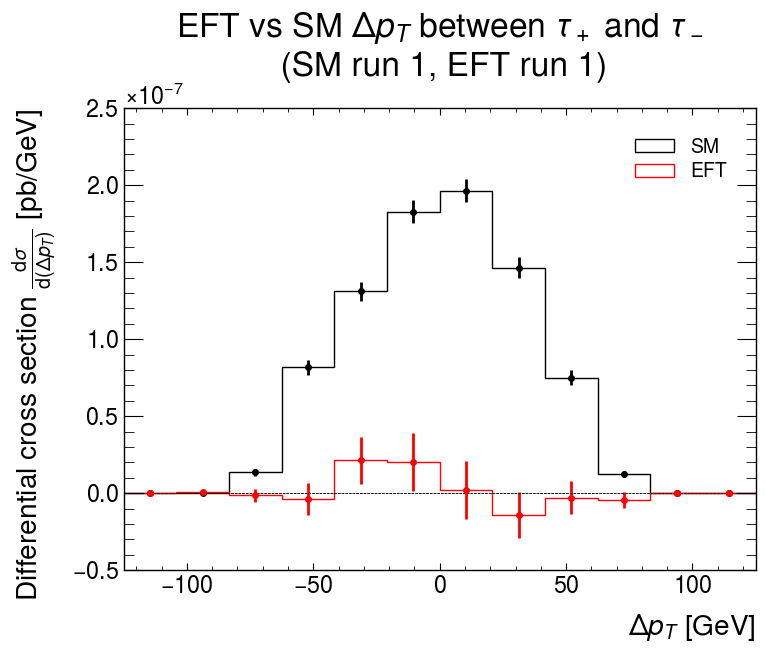

In [25]:
"""Plot the delta pt between the two taus ordered by charge
set sm and eft to the index of the sample run"""

sm = 1
eft = 1
bins = 12
plot_range = (-125, 125)

delta_pt_tau_charge_sm = delta_pt_charge(sm_taus[sm-1])
delta_pt_tau_charge_eft = delta_pt_charge(eft_taus[eft-1])

histogram(delta_pt_tau_charge_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(delta_pt_tau_charge_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$\Delta p_T$ [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta p_T)}$ [pb/GeV]')
plt.title(r'EFT vs SM $\Delta p_T$ between $\tau_+$ and $\tau_-$' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("delta_pt_tau_charge")

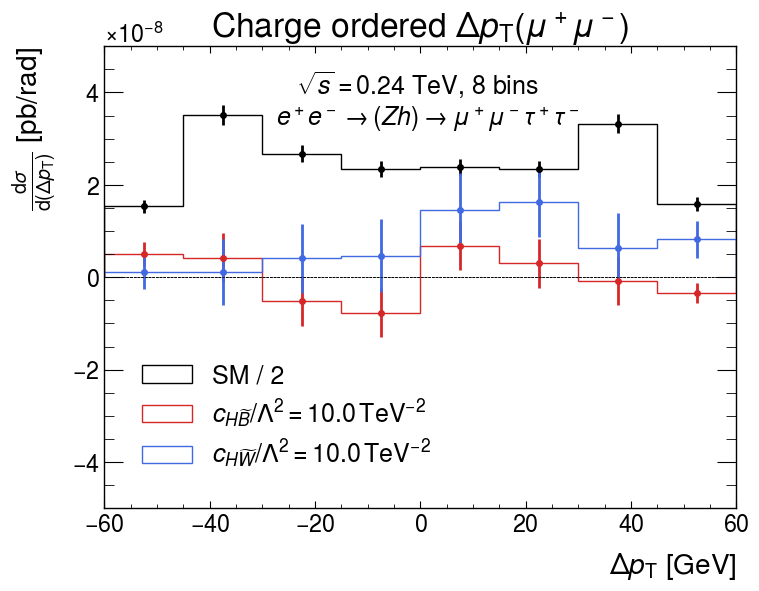

In [105]:
"""Plot the delta phi between the two muons ordered by rapidity
set sm and eft to the index of the sample run"""
sm = 1
eft = 1
bins = 8
plot_range = (-60, 60)

delta_pt_sm = delta_pt_charge(sm_muons[sm-1])
delta_pt_chb = delta_pt_charge(eft_muons[0])
delta_pt_chw = delta_pt_charge(eft_muons[1])
delta_pt_chwb = delta_pt_charge(eft_muons[2])

histogram(delta_pt_sm, sm_weights[sm-1] / 2, bins, 'SM / 2', 'k', plot_range)
plt.ylim(-0.5e-7, 0.5e-7)
histogram(delta_pt_chb, eft_weights[0], bins, r'$c_{H\widetilde{B}} / \Lambda^2 = 10.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)
histogram(delta_pt_chw, eft_weights[1], bins, r'$c_{H\widetilde{W}} / \Lambda^2 = 10.0 \, \text{TeV}^{-2}$', 'royalblue', plot_range)
# histogram(delta_pt_chwb, eft_weights[2], bins, r'$c_{H\widetilde{W}B} / \Lambda^2 = 10.0 \, \text{TeV}^{-2}$', 'darkgreen', plot_range)
plt.xlabel(r'$\Delta p_\text{T}$ [GeV]')
plt.ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta p_\text{T})}$ [pb/rad]')
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\tau_1$ and $\tau_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 1.00')
plt.title(r'Charge ordered $\Delta p_\text{T}(\mu^+ \mu^-)$')
plt.text(0.4, 0.85, r'$\sqrt{s} = 0.24$ TeV, 8 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.375, 0.8, r'$e^+ e^- \rightarrow (Z h) \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)
plt.legend(loc = 'lower left', fontsize = 18)
plt.savefig("delta_pt_mu_separate.pdf")

q:  3.1114427734377967
a =  0.07774406458917094


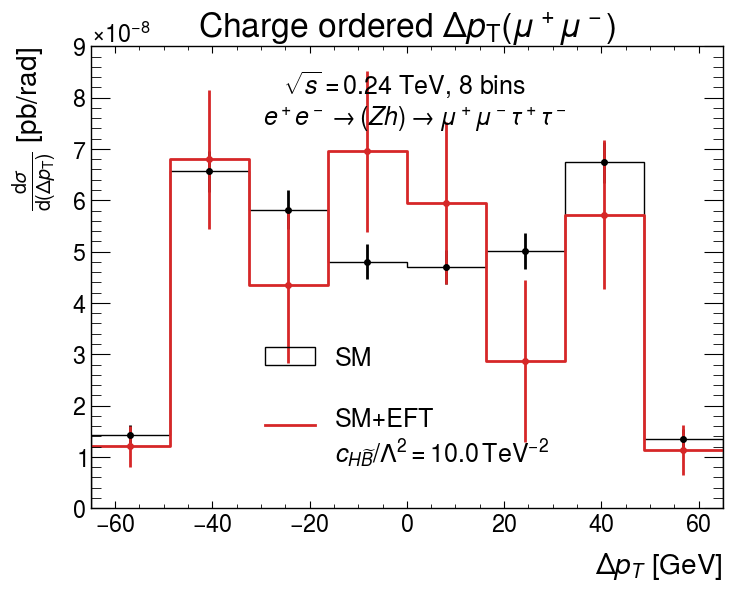

In [192]:
"""Plot the delta pt between the two muons ordered by charge
set sm and eft to the index of the sample run"""

sm = 1
# eft = 1
bins = 8
plot_range = (-65, 65) # NOTE: take care with the range! Could technically be cutting some muons off

delta_pt_mu_charge_sm = delta_pt_charge(sm_muons[sm-1])
delta_pt_mu_charge_eft = delta_pt_charge(eft_muons[eft-1])

sm_histo, sm_err, sm_diff, sm_diff_err = histogram(delta_pt_mu_charge_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err, eft_diff, eft_diff_err = histogram(delta_pt_mu_charge_eft, eft_weights[eft-1], bins, 'EFT', 'tab:red', plot_range, False)
smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, sm_diff, sm_diff_err, eft_diff, eft_diff_err, bins,
                                         '\nSM+EFT\n' + r'$c_{H\widetilde{B}} / \Lambda^2 = 10.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)

# H1 = likelihood(smeft_histo, smeft_histo)
# H0 = likelihood(smeft_histo, sm_histo[0])
# H0 = likelihood(smeft_histo, sm_histo[0])
# H1 = likelihood(sm_histo[0], sm_histo[0])
# print('H1 Likelihood: ', H1,'\nH0 Likelihood: ', H0)
# print('q: ', np_q(H0,H1))
# print('a = ', find_p_val(np_q(H0,H1), bins-1))
q = likelihood_bz(sm_histo[0], sm_err, smeft_histo, smeft_err, eft_err)
print('q: ', q)
print('a = ', find_p_val(q, 1))

plt.xlabel(r'$\Delta p_T$ [GeV]')
plt.ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta p_\text{T})}$ [pb/rad]')
# plt.title(r'EFT vs SM $\Delta p_T$ between $\mu_+$ and $\mu_-$' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 1')
plt.text(0.4, 0.85, r'$\sqrt{s} = 0.24$ TeV, 8 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.375, 0.8, r'$e^+ e^- \rightarrow (Z h) \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)
plt.title(r'Charge ordered $\Delta p_\text{T}(\mu^+ \mu^-)$')
plt.savefig("delta_pt_mu_charge.pdf")

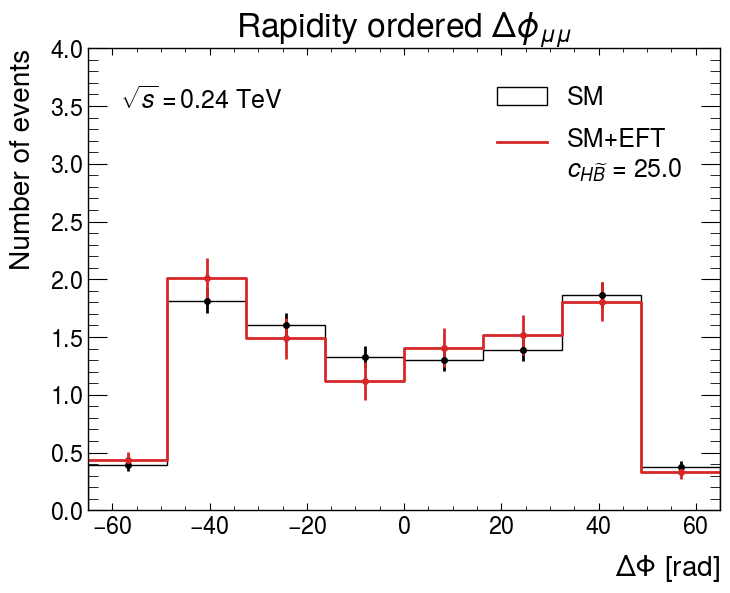

In [73]:
"""Plot above but as number of events"""
sm = 1
eft = 1
bins = 8
plot_range = (-65, 65)
luminosity = 1.7 * 10**(6) # pb^-1

delta_pt_sm = delta_pt_charge(sm_muons[sm-1])
delta_pt_eft = delta_pt_charge(eft_muons[eft-1])
# print(len(delta_phi_mu_y_sm), len(delta_phi_mu_y_eft))

sm_histo, sm_err = n_events_histo(delta_pt_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err= n_events_histo(delta_pt_eft, eft_weights[eft-1], bins, 'EFT', 'k', plot_range, False)
smeft_histo, smeft_err = n_smeft_histo(sm_histo, sm_err, eft_histo, eft_err, bins,
                                         '\nSM+EFT\n' + r'$c_{H\widetilde{B}}$ = 25.0', 'tab:red', plot_range)
plt.xlabel(r'$\Delta \Phi$ [rad]')
# plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \phi_{\mu \mu})}$ [pb/rad]')
plt.ylabel('Number of events')
plt.ylim(0, 4)
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n' + r'$c_{H\widetilde{B}}$ = 10.0')
plt.title(r'Rapidity ordered $\Delta \phi_{\mu \mu}$')
# plt.text(-2.75, 1.25e-5, r'$\sqrt{s} = 0.24$ TeV', fontsize=18)   
plt.text(0.2, 0.83, r'$\sqrt{s} = 0.24$ TeV', fontsize=18, transform=plt.gcf().transFigure)
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + '\n chbtil = 0.1')
plt.legend(fontsize = 18, labelspacing = -0.5)
plt.savefig("delta_pt_n_events.pdf")

In [75]:
import pyhf
from pyhf.contrib.viz import brazil
bkg_error = np.sqrt(sm_err)
pyhf.set_backend("numpy")
model = pyhf.simplemodels.uncorrelated_background(
    signal=eft_histo[0].tolist(),
    bkg=sm_histo[0].tolist(),
    bkg_uncertainty=bkg_error.tolist()
)

data = sm_histo[0].tolist() + model.config.auxdata
test_mu = 1.0


CLs_obs, CLs_exp = pyhf.infer.hypotest(test_mu, data, model, test_stat='qtilde', return_expected=True)
print(f"Expected: {CLs_exp:.8f}, Observed: {CLs_obs:.8f}")

Expected: 0.76481215, Observed: 0.76481215


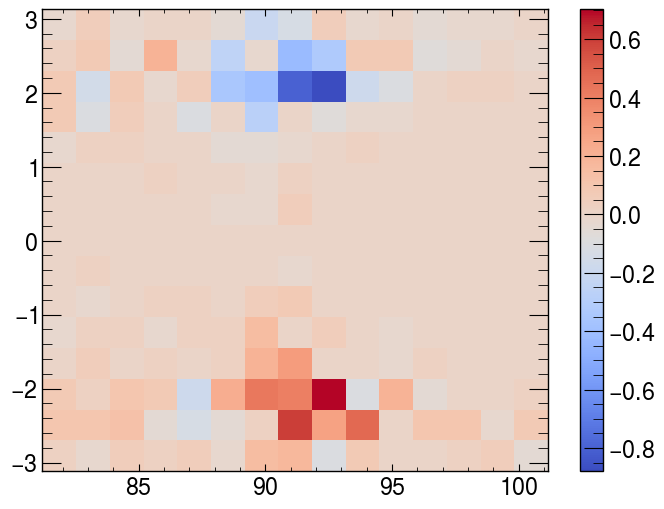

In [27]:
# sm = 1
eft = 1
bins = 12
phi_plot_range = [-math.pi, math.pi]
mass_plot_range = [0,120]
luminosity = 1.7 * 10**(6) # pb^-1

bins = 15

# delta_phi_mu_y_sm = delta_phi_rapidity(sm_muons[sm-1])
delta_phi_mu_y_eft = delta_phi_rapidity(eft_muons[eft-1])

weights = eft_weights[eft-1] * luminosity
inv_masses = return_inv_masses(eft_muons[eft-1]).tolist()

weights = [i[0] for i in weights]


plt.hist2d(inv_masses, delta_phi_mu_y_eft, bins=bins, weights = weights, cmap='coolwarm')
plt.colorbar()
plt.show()

In [194]:
"""The 'genuine' CP odd observable from https://arxiv.org/abs/0911.2933"""
def calc_Phi(a, b, cross, subtraction):
    # NOTE: this takes a while to run... is there a more efficient method?
    """This is pretty long, so let's use a function instead of writing it twice
    so for the (l+ x l-) dot z, let's do it separately - this is mayber neater anyway
    I'm very much hoping I can subtract the 4 vectors and it will act like 3-momentum
    I should check this"""
    unit_z = vector.obj(x=0, y=0, z=1)
    # start = time.time()
    # a_unit = a / a.mag
    # b_unit = b / b.mag
    # crossp = a_unit.cross(b_unit)
    # 'As I said, weirdly returns an awkward array, so I have to convert it to a vector'
    # crossp_vec = vector.obj(x=crossp.x, y=crossp.y, z=crossp.z)
    ang = math.asin((cross.dot(unit_z)))
    # sign = np.sign((a-b).dot(unit_z))
    sign = np.sign(subtraction.dot(unit_z))
    return sign*ang

def cp_Phi(leptons):
    cp_Phi = []
    crosses = cross_leptons(leptons)
    subtraction = leptons[:,0] - leptons[:,1]
    for i, lep in enumerate(leptons):
        unit_z = vector.obj(x=0, y=0, z=1)
        if lep[0].charge == 1:
            cp_Phi.append(calc_Phi(lep[0], lep[1], crosses[i], subtraction[i]))
        else:
            cp_Phi.append(calc_Phi(lep[1], lep[0], -crosses[i], -subtraction[i]))
    return cp_Phi

def cross_leptons(leptons):
    '''In the above we need the cross product of the momentum between vectors
    this is much quicker to calculate in one go and use vector.zip
    and flip the sign of where required
    This is because for some bizarre reason, .cross returns an awkward array, not a vector
    so we need to calculate and reform (zip) a vector object'''
    crosses = (leptons[:,0]/leptons[:,0].mag).cross(leptons[:,1]/leptons[:,1].mag)
    # not forgetting that the cross product needs the unit vector, so divide by mag
    crosses_vec = vector.zip({'x':ak.to_numpy(crosses.x), 'y':ak.to_numpy(crosses.y), 'z':ak.to_numpy(crosses.z)})
    '''In the end, this alone didn't make it much quicker
    it seems nicer, so I'll leave it, but may be worth returning to see if it is still right
    what made it much faster is doing a similar thing for the subtraction, so it's probably worth doing both like this'''
    return crosses_vec

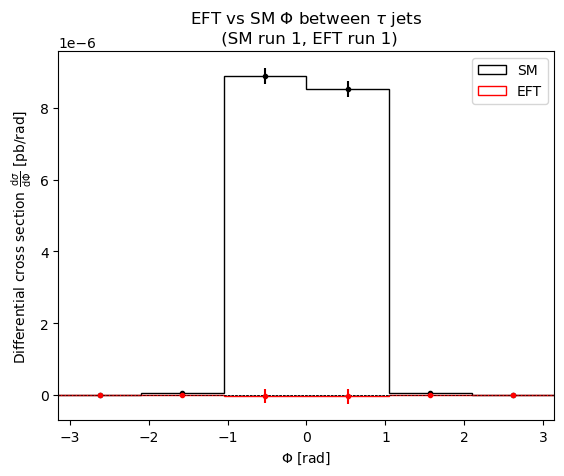

In [ ]:
"""Plot the observable Phi between the two taus ordered by charge
set sm and eft to the index of the sample run"""

sm = 1
eft = 1
bins = 6
plot_range = (-math.pi, math.pi) # NOTE: take care with the range! Could technically be cutting some muons off

cp_Phi_tau_sm = cp_Phi(sm_taus[sm-1])
cp_Phi_tau_eft = cp_Phi(eft_taus[eft-1])

histogram(cp_Phi_tau_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
histogram(cp_Phi_tau_eft, eft_weights[eft-1], bins, 'EFT', 'r', plot_range)

plt.xlabel(r'$\Phi$ [rad]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}\Phi}$ [pb/rad]')
plt.title(r'EFT vs SM $\Phi$ between $\tau$ jets' + f'\n (SM run {sm}, EFT run {eft})')
plt.savefig("cp_Phi_tau")

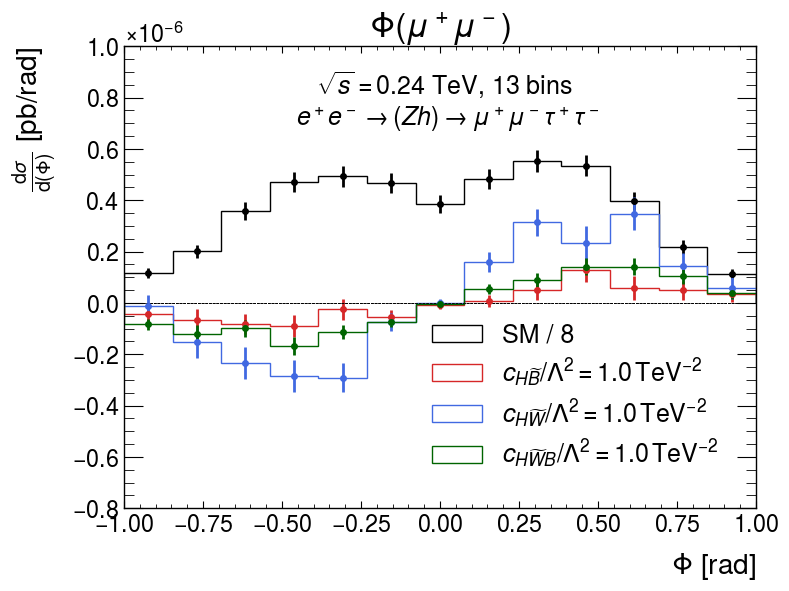

In [98]:
"""Plot the delta phi between the two muons ordered by rapidity
set sm and eft to the index of the sample run"""
sm = 1
eft = 1
bins = 13
# plot_range = (-math.pi/2, math.pi/2)
plot_range = (-1, 1)

Phi_sm= cp_Phi(sm_muons[sm-1])
Phi_chb = cp_Phi(eft_muons[0])
Phi_chw = cp_Phi(eft_muons[1])
Phi_chwb = cp_Phi(eft_muons[2])

histogram(Phi_sm, sm_weights[sm-1] / 8, bins, 'SM / 8', 'k', plot_range)
plt.ylim(-8e-7, 10e-7)
histogram(Phi_chb, eft_weights[0], bins, r'$c_{H\widetilde{B}} / \Lambda^2 = 1.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)
histogram(Phi_chw, eft_weights[1], bins, r'$c_{H\widetilde{W}} / \Lambda^2 = 1.0 \, \text{TeV}^{-2}$', 'royalblue', plot_range)
histogram(Phi_chwb, eft_weights[2], bins, r'$c_{H\widetilde{W}B} / \Lambda^2 = 1.0 \, \text{TeV}^{-2}$', 'darkgreen', plot_range)
plt.xlabel(r'$\Phi$ [rad]')
plt.ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}(\Phi)}$ [pb/rad]')
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\tau_1$ and $\tau_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 1.00')
plt.title(r'$\Phi(\mu^+\mu^-)$')
plt.text(0.4, 0.85, r'$\sqrt{s} = 0.24$ TeV, 13 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.375, 0.8, r'$e^+ e^- \rightarrow (Z h) \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)
plt.legend(loc = 'lower right', fontsize = 18)
plt.savefig("Phi_mu_separate.pdf")

In [198]:
start = 1
choice = 27
eft =choice - start + 1
# eft = 1

q:  3.7434461956662988
a =  0.05301499679321442


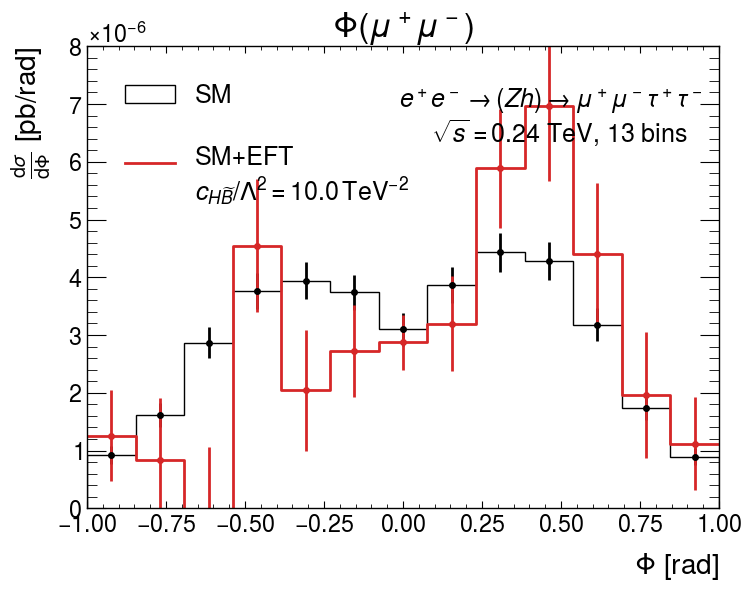

In [199]:
"""Plot the observable Phi between the two muons ordered by charge
set sm and eft to the index of the sample run"""

sm = 1
# eft = 1
# bins = 12
# plot_range = (-math.pi, math.pi) # NOTE: take care with the range! Could technically be cutting some muons off
bins = 13
# plot_range = (-math.pi/2, math.pi/2)
plot_range = (-1, 1)

cp_Phi_mu_sm = cp_Phi(sm_muons[sm-1])
cp_Phi_mu_eft = cp_Phi(eft_muons[eft-1])

sm_histo, sm_err, sm_diff, sm_diff_err = histogram(cp_Phi_mu_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err, eft_diff, eft_diff_err = histogram(cp_Phi_mu_eft, eft_weights[eft-1], bins, 'EFT', 'tab:red', plot_range, False)
smeft_histo, smeft_err = SMEFT_histogram(sm_histo, sm_err, eft_histo, eft_err, sm_diff, sm_diff_err, eft_diff, eft_diff_err, bins,
                                         '\nSM+EFT\n' + r'$c_{H\widetilde{B}} / \Lambda^2 = 10.0 \, \text{TeV}^{-2}$', 'tab:red', plot_range)

q = likelihood_bz(sm_histo[0], sm_err, smeft_histo, smeft_err, eft_err)
print('q: ', q)
print('a = ', find_p_val(q, 1))

plt.xlabel(r'$\Phi$ [rad]')
plt.ylabel(r'$\frac{\mathrm{d}\sigma}{\mathrm{d}\Phi}$ [pb/rad]')
# plt.title(r'EFT vs SM $\Phi$ between di-$\mu$ system' + f'\n (SM run {sm}, EFT run {eft}) \n chbtil = 0.1')
plt.title(r'$\Phi(\mu^+\mu^-)$')
plt.ylim(0, 8e-6)
plt.text(0.59, 0.77, r'$\sqrt{s} = 0.24$ TeV, 13 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.55, 0.83, r'$e^+ e^- \rightarrow (Z h) \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=18, transform=plt.gcf().transFigure)
plt.legend(loc = 'upper left', fontsize = 18)
plt.savefig("cp_Phi_mu.pdf")

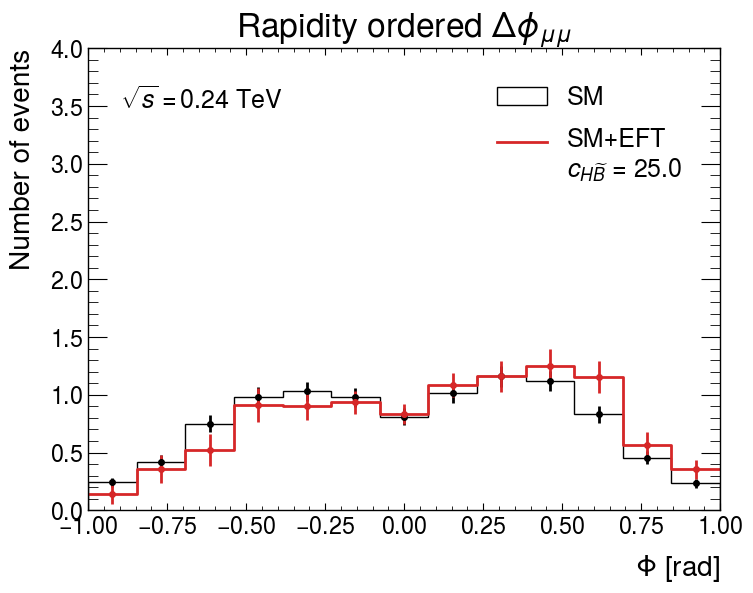

In [114]:
"""Plot above but as number of events"""
sm = 1
eft = 1
bins = 13
plot_range = (-1, 1)
luminosity = 1.7 * 10**(6) # pb^-1

Phi_sm= cp_Phi(sm_muons[sm-1])
Phi_eft = cp_Phi(eft_muons[eft-1])
# print(len(delta_phi_mu_y_sm), len(delta_phi_mu_y_eft))

sm_histo, sm_err = n_events_histo(Phi_sm, sm_weights[sm-1], bins, 'SM', 'k', plot_range)
eft_histo, eft_err= n_events_histo(Phi_eft, eft_weights[eft-1], bins, 'EFT', 'k', plot_range, False)
smeft_histo, smeft_err = n_smeft_histo(sm_histo, sm_err, eft_histo, eft_err, bins,
                                         '\nSM+EFT\n' + r'$c_{H\widetilde{B}}$ = 25.0', 'tab:red', plot_range)
plt.xlabel(r'$\Phi$ [rad]')
# plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}(\Delta \phi_{\mu \mu})}$ [pb/rad]')
plt.ylabel('Number of events')
plt.ylim(0, 4)
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + f'\n (SM run {sm}, EFT run {eft}) \n' + r'$c_{H\widetilde{B}}$ = 10.0')
plt.title(r'Rapidity ordered $\Delta \phi_{\mu \mu}$')
# plt.text(-2.75, 1.25e-5, r'$\sqrt{s} = 0.24$ TeV', fontsize=18)   
plt.text(0.2, 0.83, r'$\sqrt{s} = 0.24$ TeV', fontsize=18, transform=plt.gcf().transFigure)
# plt.title(r'EFT vs SM $\Delta \Phi$ between $\mu_1$ and $\mu_2$, ordered by rapidity' + '\n chbtil = 0.1')
plt.legend(fontsize = 18, labelspacing = -0.5)
plt.savefig("delta_Phi_n_events.pdf")

In [115]:
import pyhf
from pyhf.contrib.viz import brazil
bkg_error = np.sqrt(sm_err)
pyhf.set_backend("numpy")
model = pyhf.simplemodels.uncorrelated_background(
    signal=eft_histo[0].tolist(),
    bkg=sm_histo[0].tolist(),
    bkg_uncertainty=bkg_error.tolist()
)

data = sm_histo[0].tolist() + model.config.auxdata
test_mu = 1.0


CLs_obs, CLs_exp = pyhf.infer.hypotest(test_mu, data, model, test_stat='qtilde', return_expected=True)
print(f"Expected: {CLs_exp:.8f}, Observed: {CLs_obs:.8f}")

Expected: 0.56643659, Observed: 0.56643659


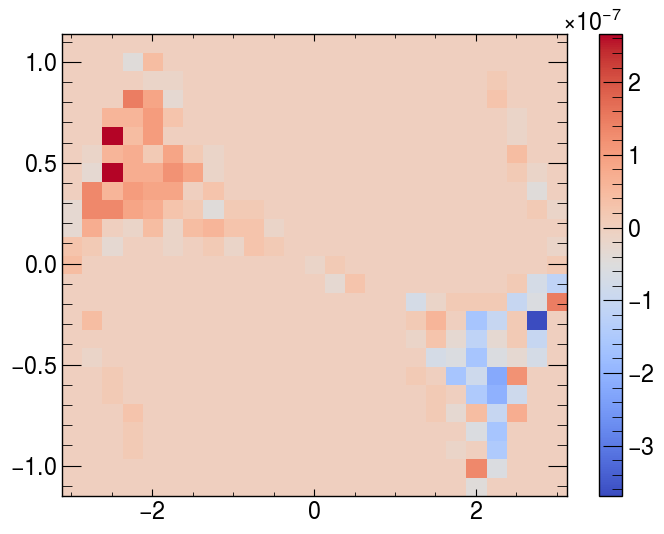

In [31]:
# sm = 1
eft = 1
bins = 12
phi_plot_range = [-math.pi, math.pi]
mass_plot_range = [0,120]
luminosity = 1.7 * 10**(6) # pb^-1

bins = 25

# delta_phi_mu_y_sm = delta_phi_rapidity(sm_muons[sm-1])
cp_Phi_mu_eft = cp_Phi(eft_muons[eft-1])
weights = eft_weights[eft-1]

inv_masses = return_inv_masses(eft_muons[eft-1]).tolist()


plt.hist2d(delta_phi_mu_y_eft, cp_Phi_mu_eft, bins=bins, weights = [i[0] for i in weights], cmap='coolwarm')
plt.colorbar()
plt.show()